In [1]:
# Ali Babolhavaeji 
# 7/3/2019

import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

from torch.utils.data import *
from PIL import Image
import numpy as np

# Downlaod CIFAR-10 data set from torchvision dataset
# first time you run the code you need downlaod the dataset
# by setting --> download=True

train_dataset = datasets.CIFAR10('Cifar10', train=True,
                              download=True)

test_dataset = datasets.CIFAR10('Cifar10', train=False,
                             download=True)
len(train_dataset),len(test_dataset)



Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [ ]:
type(train_dataset)

trainloader= DataLoader(train_dataset,
                        batch_size=50,
                        shuffle=False)
tesloader= DataLoader(test_dataset,
                        batch_size=50,
                        shuffle=False)

len(trainloader),len(tesloader)





In [35]:
#splitting data
def split_image_data(train_data,
                     test_data=None,
                     batch_size=20,
                     num_workers=0,
                     valid_size=0.2,
                     sampler=SubsetRandomSampler):
    
    num_train=len(train_data)
    indices= list(range(num_train))
    np.random.shuffle(indices)
    split=int(np.floor(valid_size*num_train))
    print(split)
    train_idx,valid_idx=indices[split:],indices[:split]
    train_sampler=sampler(train_idx)
    valid_sampler=sampler(valid_idx)
    
    if test_data is not None:
        test_loader= DataLoader(test_data, batch_size=batch_size,
                                num_workers=num_workers) 
    else:
        train_idx,test_idx= train_idx[split:],train_idx[:split]
        train_sampler=sampler(train_idx)
        test_sampler =sampler(test_idx)

        test_loader= DataLoader(train_data, batch_size=batch_size,
                                 num_workers=num_workers,
                                 sampler=test_sampler)
        
    train_loader= DataLoader(train_data, batch_size=batch_size,
                             num_workers=num_workers,
                             sampler=train_sampler)
    
    valid_loader= DataLoader(train_data,batch_size=batch_size,
                             num_workers=num_workers, 
                             sampler=valid_sampler)
    
    return train_loader, valid_loader , test_loader
#     return train_loader , test_loader
        


In [38]:
train_loder,valid_loader,test_loaser=split_image_data(
                                                        train_dataset,
                                                        batch_size=100)
len(train_loder),len(valid_loader),len(test_loaser)


10000


(300, 100, 100)

In [41]:
# We resize the images in the data set beacuse of the most pretrained model
# need high resolution images (more than 224*224)
# Add augmentation to have better training performance:
# you can do that when you read data from the dataset. 
# Fliped and rotate with specific degree of p percentage of all images for
# augmentetion

from torchvision import transforms

train_transform= transforms.Compose([transforms.Resize(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(10)])
train_dataset_Aug= datasets.CIFAR10('Cifar10',
                                   download=False,
                                   transform=train_transform)

In [135]:
# dataset Normalization
# when you do transform learning you need to know the mean and the standard
# deviation of the orginal dataset which model is learned by that.
# subtract the mean value of whole dataset from each pixel then divide
# on the standard deviation of whole dataset

from torchvision import transforms
# by this way all images will be conerted to a tensor
transform_Norm = transforms.Compose([transforms.ToTensor()])

dataset = datasets.CIFAR10('Cifar10',download=False,transform=transform_Norm)
loader = torch.utils.data.DataLoader(dataset, batch_size=50,num_workers=0)


# the mean value will be computed by the following function

def calculate_img_stats_avg(loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for imgs,_ in loader:
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean,std


def calculate_img_stats_full(dataset):
    imgs_ = torch.stack([img for img,_ in dataset],dim=3)
    imgs_ = imgs_.view(3,-1)
    imgs_mean = imgs_.mean(dim=1)
    imgs_std = imgs_.std(dim=1)
    return imgs_mean,imgs_std


In [134]:
calculate_img_stats_avg(loader)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))

In [ ]:
# calculate_img_stats_full(dataset)

In [126]:
idx=iter(loader)
img,target=next(idx)
# by this method we can get the first batch whic in each bath we have(50 images)
#based on the batch size
img[0].size(0) ,target[0]

# calculate mean value from the RGB image
print(img.shape)
# print(img[0].mean(0).shape)
# img[0].mean(0).mean(0).mean(0)
# img[0].size(0)
# img[0].view(3,img[0].size(1),-1)
# img[0].mean(1).mean(1)

img.mean(0).mean(1).mean(1).shape

torch.Size([50, 3, 32, 32])


torch.Size([3])

In [133]:
# the mean value will be computed by the following function

def calculate_img_stats_avg_2(loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for imgs,_ in loader:
        batch_samples = imgs.size(0)
        mean += (img.mean(0).mean(1).mean(1))
        nb_samples += batch_samples
    return mean/batch_samples

z=calculate_img_stats_avg_2(loader)
print(z)



tensor([9.8419, 9.3724, 8.4503])


In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [28]:
list(range(10))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

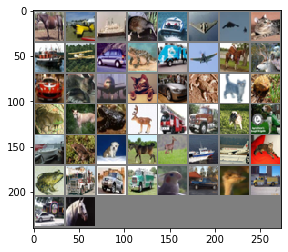

horse plane  ship  bird  ship plane plane   cat  ship plane   car  frog truck plane horse  deer   car   cat plane   cat   car  frog   cat  frog  frog   dog  frog  deer truck truck   dog   dog  ship  frog   dog horse  deer  ship plane   cat  frog truck   car truck  bird   car  bird truck   car horse


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(50)))

In [24]:
len(images)

50